# 1. Introduction
## 1.1 Summary
This analysis is a review of the 2020 United States presidential election. This election was not only an election in the real world but also a digital competition. President candidates were sending out messages online. Thus, people could react to the messages and also interact with other fans through the digital world.

## 1.2 Analytics Tool and Dataset
The given dataset is the Twitter timeline of Joe Biden, Kamala Harris, Mike Pence, and Donald Trump. There are 4 .json files. The files of Joe Biden, Kamala Harris, and Donald Trump have 200 pieces of data per each. Mike Pence has a missing one, so it has 199 pieces of data.

Transcribed:

* 02 Nov 2022
* Jon Chun




# 2. Prepare
## 2.1 Analysis Plan
The analysis plan is to answer the questions.
1. What are the most common words used in Twitter messages?
2. Which messages are the most sentimental?
3. When to post would help the messages get more retweets and likes?
4. Are threse posts retweets and from whom?
5. How accurate of a model to predict the likes that the messages are going to get?
6. How many times Biden and Trump mention each other?

## Method
This analysis will load the 4 datasets for 4 candidates, Joe Biden, Kamala Harris, Mike Pence, and Donald Trump. The analysis steps will be as follows.
1. Load the .json files and transform them into dataframes with needed columns
2. Clean the text messages
3. Plot a heatmap to easily understand when to post.
4. Use WordCloud to plot the common keywords in the messages
5. Plot a line chart to understand the frequency that Biden and Trump mention each other.
6. Plot a network to know where the retweets are from
7. Build a model to predict the level of likes and understant how accurate the model is

# 3. Process
## 3.1 Exploratory Data Analysis
This section involves data cleansing with an exploratory data analysis. It is a preparation of the dataset for further analysis. First of all, load the essential pakages.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/d/foolwuilin/picture/sentiment_01.jpg
/kaggle/input/d/foolwuilin/picture/sentiment_02.jpg
/kaggle/input/united-states-political-tweets/biden_timeline.json
/kaggle/input/united-states-political-tweets/pence_timeline.json
/kaggle/input/united-states-political-tweets/harris_timeline.json
/kaggle/input/united-states-political-tweets/trump_timeline.json


In [2]:
import pandas as pd
import numpy as np
import html
import string
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
import seaborn as sns
from pandas.io.json import json_normalize
from random import randint
import json
import time
import sys
import networkx as nx
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import igraph as ig
from plotly.graph_objs import *
from PIL import Image


Load 4 .json files and review how many pieces of data inside.

In [3]:
biden_file = '../input/united-states-political-tweets/biden_timeline.json'
harris_file = '../input/united-states-political-tweets/harris_timeline.json'
pence_file = '../input/united-states-political-tweets/pence_timeline.json'
trump_file = '../input/united-states-political-tweets/trump_timeline.json'

with open(biden_file, 'r') as file:
    biden_data = json.load(file)

with open(harris_file, 'r') as file:
    harris_data = json.load(file)

with open(pence_file, 'r') as file:
    pence_data = json.load(file)

with open(trump_file, 'r') as file:
    trump_data = json.load(file)

print([len(biden_data), len(harris_data), len(pence_data), len(trump_data)])

[200, 200, 199, 200]


In [4]:
biden_data[0]

{'created_at': 'Thu Oct 22 00:30:00 +0000 2020',
 'id': 1319073483943407617,
 'id_str': '1319073483943407617',
 'text': 'Folks, if you plan to vote by mail and haven’t requested your ballot yet, it’s important that you do so as soon as… https://t.co/LlS8JP7Nj4',
 'truncated': True,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [{'url': 'https://t.co/LlS8JP7Nj4',
    'expanded_url': 'https://twitter.com/i/web/status/1319073483943407617',
    'display_url': 'twitter.com/i/web/status/1…',
    'indices': [116, 139]}]},
 'source': '<a href="https://studio.twitter.com" rel="nofollow">Twitter Media Studio</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 939091,
  'id_str': '939091',
  'name': 'Joe Biden',
  'screen_name': 'JoeBiden',
  'location': 'Wilmington, DE',
  'description': 'Senator, Vice President, 2020 candidate 


Turn the raw data into dataframes. There are some zero values in the favorites column. Thus, replace these 0 values with the average number of the favorites. This approach is only applied to Biden and Trump's data because only these two dataframe will be used for generating the predicted model by the favorite count. Additionally, add a column with the word count of the text.

In [5]:
df_biden = pd.DataFrame([t['created_at'] for t in biden_data], columns=['create_time'])
df_biden['text'] = [t['text'] for t in biden_data]
df_biden['retweets'] = [t['retweet_count'] for t in biden_data]
df_biden['favorites'] = [t['favorite_count'] for t in biden_data]

biden_tokens = [word_tokenize(m) for m in df_biden['text']]
biden_tokens_cleaned = [[q for q in p if q.isalpha()] for p in biden_tokens]
biden_token_list = []
for n in range(len(biden_tokens_cleaned)):
     biden_token_list.append(len(biden_tokens_cleaned[n]))
df_biden['word_tokens'] = biden_token_list

df_biden

,create_time,text,retweets,favorites,word_tokens
0,Thu Oct 22 00:30:00 +0000 2020,"Folks, if you plan to vote by mail and haven’t...",1181,4677,25
1,Wed Oct 21 23:50:00 +0000 2020,Vote early.\n\nVote by mail.\n\nVote on Electi...,2921,19363,15
2,Wed Oct 21 23:15:00 +0000 2020,President Trump didn't take the necessary prec...,10607,74966,21
3,Wed Oct 21 21:47:08 +0000 2020,I couldn’t be more excited to have my friend @...,4454,28721,21
4,Wed Oct 21 21:05:00 +0000 2020,It’s time we replace Secretary Betsy DeVos wit...,14701,84864,20
...,...,...,...,...,...
195,Fri Oct 09 21:25:20 +0000 2020,Tune in as I deliver remarks from our drive-in...,2846,12931,13
196,Fri Oct 09 20:05:00 +0000 2020,"It’s estimated that nearly another 200,000 Ame...",18085,99806,20
197,Fri Oct 09 18:52:00 +0000 2020,Why did Donald Trump tell Bob Woodward the tru...,45574,295094,15
198,Fri Oct 09 18:27:16 +0000 2020,RT @TeamJoe: Are you an extrovert?\nAre you an...,559,0,23


In [6]:
avg_favorites_biden = round(df_biden.loc[df_biden['favorites']!=0, 'favorites'].mean(), 2)
df_biden=df_biden.replace({'favorites': {0: avg_favorites_biden}})
df_biden

,create_time,text,retweets,favorites,word_tokens
0,Thu Oct 22 00:30:00 +0000 2020,"Folks, if you plan to vote by mail and haven’t...",1181,4677.00,25
1,Wed Oct 21 23:50:00 +0000 2020,Vote early.\n\nVote by mail.\n\nVote on Electi...,2921,19363.00,15
2,Wed Oct 21 23:15:00 +0000 2020,President Trump didn't take the necessary prec...,10607,74966.00,21
3,Wed Oct 21 21:47:08 +0000 2020,I couldn’t be more excited to have my friend @...,4454,28721.00,21
4,Wed Oct 21 21:05:00 +0000 2020,It’s time we replace Secretary Betsy DeVos wit...,14701,84864.00,20
...,...,...,...,...,...
195,Fri Oct 09 21:25:20 +0000 2020,Tune in as I deliver remarks from our drive-in...,2846,12931.00,13
196,Fri Oct 09 20:05:00 +0000 2020,"It’s estimated that nearly another 200,000 Ame...",18085,99806.00,20
197,Fri Oct 09 18:52:00 +0000 2020,Why did Donald Trump tell Bob Woodward the tru...,45574,295094.00,15
198,Fri Oct 09 18:27:16 +0000 2020,RT @TeamJoe: Are you an extrovert?\nAre you an...,559,106634.55,23


In [7]:
df_harris = pd.DataFrame([t['created_at'] for t in harris_data], columns=['create_time'])
df_harris['text'] = [t['text'] for t in harris_data]
df_harris['retweets'] = [t['retweet_count'] for t in harris_data]
df_harris['favorites'] = [t['favorite_count'] for t in harris_data]

harris_tokens = [word_tokenize(m) for m in df_harris['text']]
harris_tokens_cleaned = [[q for q in p if q.isalpha()] for p in harris_tokens]
harris_token_list = []
for n in range(len(harris_tokens_cleaned)):
     harris_token_list.append(len(harris_tokens_cleaned[n]))
df_harris['word_tokens'] = harris_token_list

df_harris

,create_time,text,retweets,favorites,word_tokens
0,Thu Oct 22 00:41:00 +0000 2020,We're just days away from the end of the elect...,733,4221,19
1,Wed Oct 21 23:29:52 +0000 2020,545 children. \n\nThis is outrageous and a sta...,3100,17262,15
2,Wed Oct 21 22:51:39 +0000 2020,This is our moment to do something for our fam...,982,5514,21
3,Wed Oct 21 21:47:21 +0000 2020,.@BarackObama knows that the election is happe...,1621,9163,19
4,Wed Oct 21 20:21:01 +0000 2020,RT @JoeBiden: Tune in as @BarackObama sits dow...,4097,0,23
...,...,...,...,...,...
195,Fri Oct 02 20:04:59 +0000 2020,"RT @JoeBiden: Tonight, @BarackObama, @KamalaHa...",5771,0,16
196,Fri Oct 02 17:47:11 +0000 2020,Both @DouglasEmhoff and I were tested for COVI...,18351,181235,18
197,Fri Oct 02 16:31:50 +0000 2020,RT @JoeBiden: I’m happy to report that Jill an...,135093,0,26
198,Fri Oct 02 13:17:04 +0000 2020,Doug and I join Joe Biden and Dr. Biden in wis...,13727,176398,22


In [8]:
df_pence = pd.DataFrame([t['created_at'] for t in pence_data], columns=['create_time'])
df_pence['text'] = [t['text'] for t in pence_data]
df_pence['retweets'] = [t['retweet_count'] for t in pence_data]
df_pence['favorites'] = [t['favorite_count'] for t in pence_data]

pence_tokens = [word_tokenize(m) for m in df_pence['text']]
pence_tokens_cleaned = [[q for q in p if q.isalpha()] for p in pence_tokens]
pence_token_list = []
for n in range(len(pence_tokens_cleaned)):
     pence_token_list.append(len(pence_tokens_cleaned[n]))
df_pence['word_tokens'] = pence_token_list

df_pence

,create_time,text,retweets,favorites,word_tokens
0,Thu Oct 22 00:49:33 +0000 2020,RT @realDonaldTrump: THANK YOU NORTH CAROLINA!...,3614,0,7
1,Thu Oct 22 00:49:24 +0000 2020,RT @realDonaldTrump: The Radical Biden-Harris ...,2819,0,19
2,Thu Oct 22 00:37:55 +0000 2020,"RT @KarenPence: Great day in Mount Joy, Pennsy...",253,0,20
3,Thu Oct 22 00:36:22 +0000 2020,RT @TeamTrump: President @realDonaldTrump: The...,657,0,20
4,Thu Oct 22 00:36:11 +0000 2020,"RT @TrumpWarRoom: Claim: “On day one, Joe Bide...",3297,0,17
...,...,...,...,...,...
194,Thu Oct 15 02:12:21 +0000 2020,RT @realDonaldTrump: THANK YOU IOWA! #MAGA htt...,12713,0,7
195,Thu Oct 15 02:12:07 +0000 2020,RT @SecondLady: Informative meeting with senio...,553,0,16
196,Thu Oct 15 01:45:48 +0000 2020,RT @SecondLady: To our Nation's #MilitarySpous...,610,0,21
197,Wed Oct 14 23:55:28 +0000 2020,RT @TeamTrump: LIVE: President Donald Trump in...,2408,0,15


In [9]:
df_trump = pd.json_normalize(trump_data)
df_trump = df_trump[['created_at', 'text', 'retweet_count', 'favorite_count']]
df_trump = df_trump.rename(columns={"created_at": "create_time", 'retweet_count':'retweets', 'favorite_count':'favorites'})

trump_tokens = [word_tokenize(m) for m in df_trump['text']]
trump_tokens_cleaned = [[q for q in p if q.isalpha()] for p in trump_tokens]
trump_token_list = []
for n in range(len(trump_tokens_cleaned)):
     trump_token_list.append(len(trump_tokens_cleaned[n]))
df_trump['word_tokens'] = trump_token_list

df_trump

,create_time,text,retweets,favorites,word_tokens
0,Wed Oct 21 22:41:26 +0000 2020,Exclusive: Forgotten by Obama-Biden Auto Bailo...,6171,18497,17
1,Wed Oct 21 22:41:19 +0000 2020,Multiple Pro-Trump Demonstrations Planned in C...,6555,26744,9
2,Wed Oct 21 22:33:24 +0000 2020,Pennsylvania Trump Voters Show Passion: ‘He‘s ...,6033,24106,20
3,Wed Oct 21 22:31:37 +0000 2020,WSJ Editorial Board: Joe Biden Must Answer Que...,9732,29527,16
4,Wed Oct 21 21:57:10 +0000 2020,See you soon North Carolina! https://t.co/MWfy...,6711,33761,7
...,...,...,...,...,...
195,Fri Oct 16 11:00:50 +0000 2020,Thank you LIBERTARIANS. We are getting it all ...,14286,62059,14
196,Fri Oct 16 10:57:56 +0000 2020,RT @RandPaul: #AmyConeyBarrett will make an ex...,12820,0,21
197,Fri Oct 16 10:57:47 +0000 2020,RT @RandPaul: Democrats seem to think all just...,7879,0,24
198,Fri Oct 16 10:57:01 +0000 2020,The process has long begun. Happening fast! ht...,8479,32900,8


In [10]:
avg_favorites_trump = round(df_trump.loc[df_trump['favorites']!=0, 'favorites'].mean(), 2)
df_trump=df_trump.replace({'favorites': {0: avg_favorites_trump}})
df_trump

,create_time,text,retweets,favorites,word_tokens
0,Wed Oct 21 22:41:26 +0000 2020,Exclusive: Forgotten by Obama-Biden Auto Bailo...,6171,18497.00,17
1,Wed Oct 21 22:41:19 +0000 2020,Multiple Pro-Trump Demonstrations Planned in C...,6555,26744.00,9
2,Wed Oct 21 22:33:24 +0000 2020,Pennsylvania Trump Voters Show Passion: ‘He‘s ...,6033,24106.00,20
3,Wed Oct 21 22:31:37 +0000 2020,WSJ Editorial Board: Joe Biden Must Answer Que...,9732,29527.00,16
4,Wed Oct 21 21:57:10 +0000 2020,See you soon North Carolina! https://t.co/MWfy...,6711,33761.00,7
...,...,...,...,...,...
195,Fri Oct 16 11:00:50 +0000 2020,Thank you LIBERTARIANS. We are getting it all ...,14286,62059.00,14
196,Fri Oct 16 10:57:56 +0000 2020,RT @RandPaul: #AmyConeyBarrett will make an ex...,12820,96763.49,21
197,Fri Oct 16 10:57:47 +0000 2020,RT @RandPaul: Democrats seem to think all just...,7879,96763.49,24
198,Fri Oct 16 10:57:01 +0000 2020,The process has long begun. Happening fast! ht...,8479,32900.00,8



Start cleaning the text for the further WordCloud graphics. In addition, add the polarity and subjectivity columns for sentiment scores.

In [11]:
stop_words = set(stopwords.words('english'))

def text_cleanup(c):
    clean_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', c)))
    clean_noemoji = clean_unesc.encode('ascii', 'ignore').decode('ascii')
    wt = word_tokenize(clean_noemoji.lower())
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    return ' '.join(wt_filt)

def sentim_polarity(s):
    return TextBlob(s).sentiment.polarity

def sentim_subject(s):
    return TextBlob(s).sentiment.subjectivity

In [12]:
df_biden['text_clean'] = df_biden['text'].apply(text_cleanup)
df_biden

,create_time,text,retweets,favorites,word_tokens,text_clean
0,Thu Oct 22 00:30:00 +0000 2020,"Folks, if you plan to vote by mail and haven’t...",1181,4677.00,25,folks plan vote mail havent requested ballot y...
1,Wed Oct 21 23:50:00 +0000 2020,Vote early.\n\nVote by mail.\n\nVote on Electi...,2921,19363.00,15,vote early vote mail vote election day make su...
2,Wed Oct 21 23:15:00 +0000 2020,President Trump didn't take the necessary prec...,10607,74966.00,21,president trump take necessary precautions pro...
3,Wed Oct 21 21:47:08 +0000 2020,I couldn’t be more excited to have my friend @...,4454,28721.00,21,couldnt excited friend barackobama hitting cam...
4,Wed Oct 21 21:05:00 +0000 2020,It’s time we replace Secretary Betsy DeVos wit...,14701,84864.00,20,time replace secretary betsy devos actual publ...
...,...,...,...,...,...,...
195,Fri Oct 09 21:25:20 +0000 2020,Tune in as I deliver remarks from our drive-in...,2846,12931.00,13,tune deliver remarks event las vegas
196,Fri Oct 09 20:05:00 +0000 2020,"It’s estimated that nearly another 200,000 Ame...",18085,99806.00,20,estimated nearly another americans could lose ...
197,Fri Oct 09 18:52:00 +0000 2020,Why did Donald Trump tell Bob Woodward the tru...,45574,295094.00,15,donald trump tell bob woodward truth american ...
198,Fri Oct 09 18:27:16 +0000 2020,RT @TeamJoe: Are you an extrovert?\nAre you an...,559,106634.55,23,rt teamjoe extrovert introvert introverted ext...


In [13]:
df_biden['polarity'] = df_biden['text_clean'].apply(sentim_polarity)
df_biden['subjectivity'] = df_biden['text_clean'].apply(sentim_subject)
df_biden

,create_time,text,retweets,favorites,word_tokens,text_clean,polarity,subjectivity
0,Thu Oct 22 00:30:00 +0000 2020,"Folks, if you plan to vote by mail and haven’t...",1181,4677.00,25,folks plan vote mail havent requested ballot y...,0.4000,1.000000
1,Wed Oct 21 23:50:00 +0000 2020,Vote early.\n\nVote by mail.\n\nVote on Electi...,2921,19363.00,15,vote early vote mail vote election day make su...,0.3000,0.594444
2,Wed Oct 21 23:15:00 +0000 2020,President Trump didn't take the necessary prec...,10607,74966.00,21,president trump take necessary precautions pro...,0.0000,1.000000
3,Wed Oct 21 21:47:08 +0000 2020,I couldn’t be more excited to have my friend @...,4454,28721.00,21,couldnt excited friend barackobama hitting cam...,0.3125,0.541667
4,Wed Oct 21 21:05:00 +0000 2020,It’s time we replace Secretary Betsy DeVos wit...,14701,84864.00,20,time replace secretary betsy devos actual publ...,0.0000,0.077778
...,...,...,...,...,...,...,...,...
195,Fri Oct 09 21:25:20 +0000 2020,Tune in as I deliver remarks from our drive-in...,2846,12931.00,13,tune deliver remarks event las vegas,0.0000,0.000000
196,Fri Oct 09 20:05:00 +0000 2020,"It’s estimated that nearly another 200,000 Ame...",18085,99806.00,20,estimated nearly another americans could lose ...,0.1000,0.400000
197,Fri Oct 09 18:52:00 +0000 2020,Why did Donald Trump tell Bob Woodward the tru...,45574,295094.00,15,donald trump tell bob woodward truth american ...,0.0000,0.000000
198,Fri Oct 09 18:27:16 +0000 2020,RT @TeamJoe: Are you an extrovert?\nAre you an...,559,106634.55,23,rt teamjoe extrovert introvert introverted ext...,0.0000,0.000000


In [14]:
df_harris['text_clean'] = df_harris['text'].apply(text_cleanup)
df_harris['polarity'] = df_harris['text_clean'].apply(sentim_polarity)
df_harris['subjectivity'] = df_harris['text_clean'].apply(sentim_subject)
df_harris

,create_time,text,retweets,favorites,word_tokens,text_clean,polarity,subjectivity
0,Thu Oct 22 00:41:00 +0000 2020,We're just days away from the end of the elect...,733,4221,19,days away end election help us bring home dona...,0.000000,0.000000
1,Wed Oct 21 23:29:52 +0000 2020,545 children. \n\nThis is outrageous and a sta...,3100,17262,15,545 children outrageous stain national charact...,-1.000000,1.000000
2,Wed Oct 21 22:51:39 +0000 2020,This is our moment to do something for our fam...,982,5514,21,moment something families communities country ...,0.000000,0.000000
3,Wed Oct 21 21:47:21 +0000 2020,.@BarackObama knows that the election is happe...,1621,9163,19,barackobama knows election happening right win...,0.392857,0.642857
4,Wed Oct 21 20:21:01 +0000 2020,RT @JoeBiden: Tune in as @BarackObama sits dow...,4097,0,23,rt joebiden tune barackobama sits community le...,0.000000,0.000000
...,...,...,...,...,...,...,...,...
195,Fri Oct 02 20:04:59 +0000 2020,"RT @JoeBiden: Tonight, @BarackObama, @KamalaHa...",5771,0,16,rt joebiden tonight barackobama kamalaharris m...,0.000000,0.000000
196,Fri Oct 02 17:47:11 +0000 2020,Both @DouglasEmhoff and I were tested for COVI...,18351,181235,18,douglasemhoff tested morning thankfully tested...,-0.300000,0.400000
197,Fri Oct 02 16:31:50 +0000 2020,RT @JoeBiden: I’m happy to report that Jill an...,135093,0,26,rt joebiden im happy report jill tested negati...,0.250000,0.700000
198,Fri Oct 02 13:17:04 +0000 2020,Doug and I join Joe Biden and Dr. Biden in wis...,13727,176398,22,doug join joe biden biden wishing president tr...,0.300000,0.441667


In [15]:
df_pence['text_clean'] = df_pence['text'].apply(text_cleanup)
df_pence['polarity'] = df_pence['text_clean'].apply(sentim_polarity)
df_pence['subjectivity'] = df_pence['text_clean'].apply(sentim_subject)
df_pence

,create_time,text,retweets,favorites,word_tokens,text_clean,polarity,subjectivity
0,Thu Oct 22 00:49:33 +0000 2020,RT @realDonaldTrump: THANK YOU NORTH CAROLINA!...,3614,0,7,rt realdonaldtrump thank north carolina,0.000000,0.000000
1,Thu Oct 22 00:49:24 +0000 2020,RT @realDonaldTrump: The Radical Biden-Harris ...,2819,0,19,rt realdonaldtrump radical agenda projected sl...,-0.166667,0.500000
2,Thu Oct 22 00:37:55 +0000 2020,"RT @KarenPence: Great day in Mount Joy, Pennsy...",253,0,20,rt karenpence great day mount joy pennsylvania...,0.800000,0.475000
3,Thu Oct 22 00:36:22 +0000 2020,RT @TeamTrump: President @realDonaldTrump: The...,657,0,20,rt teamtrump president realdonaldtrump first t...,0.250000,0.333333
4,Thu Oct 22 00:36:11 +0000 2020,"RT @TrumpWarRoom: Claim: “On day one, Joe Bide...",3297,0,17,rt trumpwarroom claim day one joe bidens going...,0.350000,0.650000
...,...,...,...,...,...,...,...,...
194,Thu Oct 15 02:12:21 +0000 2020,RT @realDonaldTrump: THANK YOU IOWA! #MAGA htt...,12713,0,7,rt realdonaldtrump thank iowa maga,0.000000,0.000000
195,Thu Oct 15 02:12:07 +0000 2020,RT @SecondLady: Informative meeting with senio...,553,0,16,rt secondlady informative meeting senior milit...,-0.100000,0.100000
196,Thu Oct 15 01:45:48 +0000 2020,RT @SecondLady: To our Nation's #MilitarySpous...,610,0,21,rt secondlady nation militaryspouses incredibl...,0.550000,0.550000
197,Wed Oct 14 23:55:28 +0000 2020,RT @TeamTrump: LIVE: President Donald Trump in...,2408,0,15,rt teamtrump live president donald trump des m...,0.136364,0.500000


In [16]:
df_trump['text_clean'] = df_trump['text'].apply(text_cleanup)
df_trump['polarity'] = df_trump['text_clean'].apply(sentim_polarity)
df_trump['subjectivity'] = df_trump['text_clean'].apply(sentim_subject)
df_trump

,create_time,text,retweets,favorites,word_tokens,text_clean,polarity,subjectivity
0,Wed Oct 21 22:41:26 +0000 2020,Exclusive: Forgotten by Obama-Biden Auto Bailo...,6171,18497.00,17,exclusive forgotten auto bailout delphi worker...,0.000,0.00
1,Wed Oct 21 22:41:19 +0000 2020,Multiple Pro-Trump Demonstrations Planned in C...,6555,26744.00,9,multiple demonstrations planned cincinnati are...,0.000,0.00
2,Wed Oct 21 22:33:24 +0000 2020,Pennsylvania Trump Voters Show Passion: ‘He‘s ...,6033,24106.00,20,pennsylvania trump voters show passion hes man...,0.200,0.10
3,Wed Oct 21 22:31:37 +0000 2020,WSJ Editorial Board: Joe Biden Must Answer Que...,9732,29527.00,16,wsj editorial board joe biden must answer ques...,0.000,0.00
4,Wed Oct 21 21:57:10 +0000 2020,See you soon North Carolina! https://t.co/MWfy...,6711,33761.00,7,see soon north carolina,0.000,0.00
...,...,...,...,...,...,...,...,...
195,Fri Oct 16 11:00:50 +0000 2020,Thank you LIBERTARIANS. We are getting it all ...,14286,62059.00,14,thank libertarians getting done fast vote trump,0.200,0.60
196,Fri Oct 16 10:57:56 +0000 2020,RT @RandPaul: #AmyConeyBarrett will make an ex...,12820,96763.49,21,rt randpaul amyconeybarrett make excellent jus...,1.000,1.00
197,Fri Oct 16 10:57:47 +0000 2020,RT @RandPaul: Democrats seem to think all just...,7879,96763.49,24,rt randpaul democrats seem think justices poli...,0.000,0.00
198,Fri Oct 16 10:57:01 +0000 2020,The process has long begun. Happening fast! ht...,8479,32900.00,8,process long begun happening fast,0.075,0.50


Prepare dataframes containing the propotion of the retweets and favorites in different hours. Then, plot a heatmap to understand when to post to get the highest retweets and favorites. 

In [17]:
df_biden_post = df_biden[['create_time', 'retweets', 'favorites']]
df_biden_post

,create_time,retweets,favorites
0,Thu Oct 22 00:30:00 +0000 2020,1181,4677.00
1,Wed Oct 21 23:50:00 +0000 2020,2921,19363.00
2,Wed Oct 21 23:15:00 +0000 2020,10607,74966.00
3,Wed Oct 21 21:47:08 +0000 2020,4454,28721.00
4,Wed Oct 21 21:05:00 +0000 2020,14701,84864.00
...,...,...,...
195,Fri Oct 09 21:25:20 +0000 2020,2846,12931.00
196,Fri Oct 09 20:05:00 +0000 2020,18085,99806.00
197,Fri Oct 09 18:52:00 +0000 2020,45574,295094.00
198,Fri Oct 09 18:27:16 +0000 2020,559,106634.55


In [18]:
biden_time_list = pd.to_datetime(df_biden_post['create_time'], format='%a %b %d %H:%M:%S +0000 %Y')
df_biden_post = df_biden_post.assign(create_time=biden_time_list)
biden_hour_list = df_biden_post['create_time'].dt.strftime('%H')
df_biden_post = df_biden_post.assign(create_hour=biden_hour_list)
biden_post_avg = df_biden_post.groupby('create_hour').mean().round(2)
biden_post_avg

,retweets,favorites
create_hour,,
00,28100.06,193277.78
01,15941.83,112809.83
02,7673.00,75704.25
03,26201.00,111755.00
12,181153.00,1276993.00
13,42280.60,348172.60
14,9512.50,69182.21
15,11331.12,50519.07
16,14331.00,91918.08


In [19]:
biden_max_retweets = biden_post_avg.loc[:, 'retweets'].max()
biden_max_likes = biden_post_avg.loc[:, 'favorites'].max()
biden_post_avg['retweet_percent'] = (biden_post_avg['retweets'] / biden_max_retweets).round(2)
biden_post_avg['like_percent'] = (biden_post_avg['favorites'] / biden_max_likes).round(2)
biden_post_avg.head()

,retweets,favorites,retweet_percent,like_percent
create_hour,,,,
00,28100.06,193277.78,0.16,0.15
01,15941.83,112809.83,0.09,0.09
02,7673.00,75704.25,0.04,0.06
03,26201.00,111755.00,0.14,0.09
12,181153.00,1276993.00,1.00,1.00


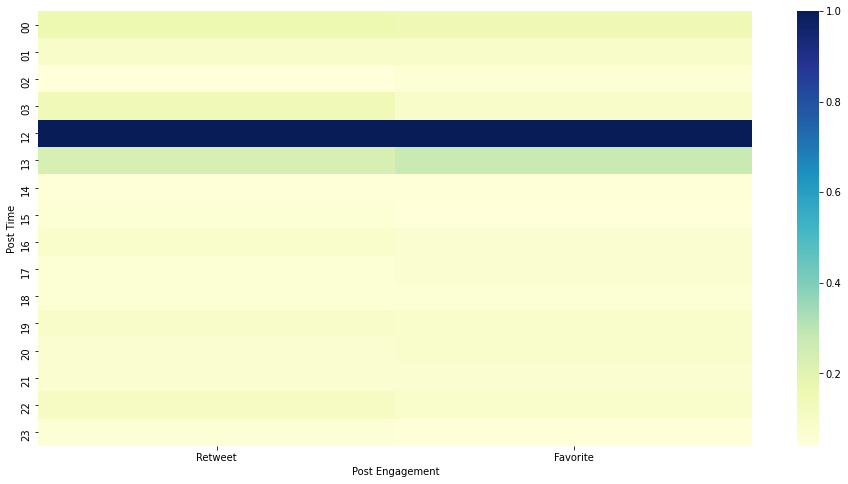

In [20]:
biden_post_heatmap = biden_post_avg[['retweet_percent', 'like_percent']]
plt.subplots(figsize=(16, 8))
g = sns.heatmap(biden_post_heatmap, cmap = 'YlGnBu')
g.set_xticklabels(['Retweet','Favorite'])
plt.xlabel('Post Engagement')
plt.ylabel('Post Time')
plt.show()

In [21]:
df_trump_post = df_trump[['create_time', 'retweets', 'favorites']]

trump_time_list = pd.to_datetime(df_trump_post['create_time'], format='%a %b %d %H:%M:%S +0000 %Y')
df_trump_post = df_trump_post.assign(create_time=trump_time_list)
trump_hour_list = df_trump_post['create_time'].dt.strftime('%H')
df_trump_post = df_trump_post.assign(create_hour=trump_hour_list)
trump_post_avg = df_trump_post.groupby('create_hour').mean().round(2)

trump_max_retweets = trump_post_avg.loc[:, 'retweets'].max()
trump_max_likes = trump_post_avg.loc[:, 'favorites'].max()
trump_post_avg['retweet_percent'] = (trump_post_avg['retweets'] / trump_max_retweets).round(2)
trump_post_avg['like_percent'] = (trump_post_avg['favorites'] / trump_max_likes).round(2)
trump_post_avg.head()

,retweets,favorites,retweet_percent,like_percent
create_hour,,,,
01,22961.60,95265.50,0.49,0.50
02,20830.40,80340.35,0.44,0.42
04,18401.83,94321.37,0.39,0.49
05,31962.67,125330.50,0.68,0.65
10,8625.75,63121.74,0.18,0.33


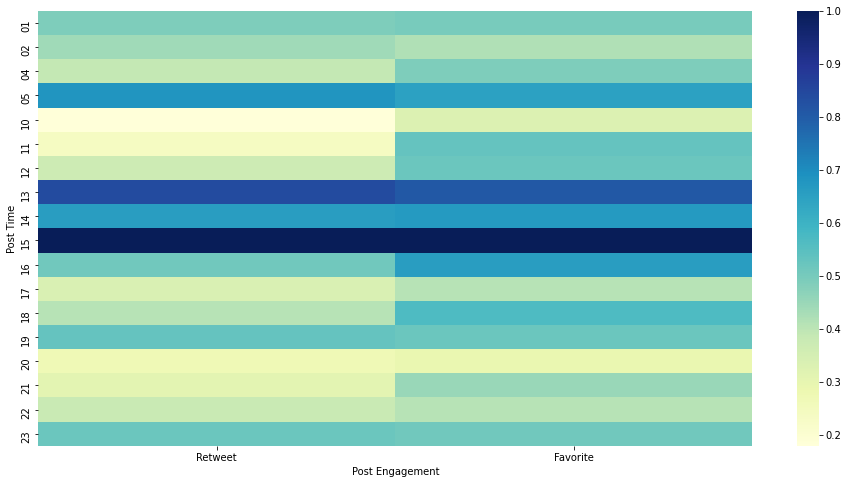

In [22]:
trump_post_heatmap = trump_post_avg[['retweet_percent', 'like_percent']]
plt.subplots(figsize=(16, 8))
g = sns.heatmap(trump_post_heatmap, cmap = 'YlGnBu')
g.set_xticklabels(['Retweet','Favorite'])
plt.xlabel('Post Engagement')
plt.ylabel('Post Time')
plt.show()


Define color settings for WordCloud. Plot the graphics for Biden and Trump's text (cleaned text) to understand the most common keywords of the messages.

In [23]:
def similar_color_blue(word=None, font_size=None, position=None, orientation=None,
font_path=None, random_state=None):
    h = 220 # 0 - 360
    s = 60 # 0 - 100
    l = random_state.randint(30, 70) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

def similar_color_black(word=None, font_size=None, position=None, orientation=None,
font_path=None, random_state=None):
    h = 220 # 0 - 360
    s = 0 # 0 - 100
    l = random_state.randint(10, 70) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

def similar_color_red(word=None, font_size=None, position=None, orientation=None,
font_path=None, random_state=None):
    h = 0 # 0 - 360
    s = 100 # 0 - 100
    l = random_state.randint(10, 70) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

def similar_color_green(word=None, font_size=None, position=None, orientation=None,
font_path=None, random_state=None):
    h = 140 # 0 - 360
    s = 100 # 0 - 100
    l = random_state.randint(10, 70) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

def similar_color_orange(word=None, font_size=None, position=None, orientation=None,
font_path=None, random_state=None):
    h = 40 # 0 - 360
    s = 100 # 0 - 100
    l = random_state.randint(10, 70) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

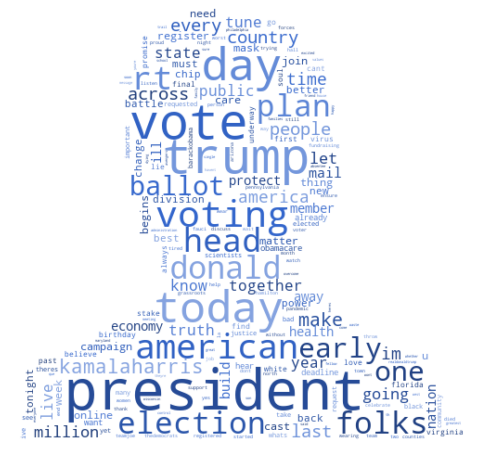

In [24]:
biden_text_clean = ' '.join(df_biden['text_clean'])
biden_picture = '../input/d/foolwuilin/picture/sentiment_01.jpg'

mask = np.array(Image.open(biden_picture))
plt.subplots(figsize=(16, 8))
wc = WordCloud(width=mask.shape[1], height=mask.shape[0], max_font_size=60, 
               collocations=False, mask=mask, background_color='white',
              random_state=44, color_func=similar_color_blue).generate(biden_text_clean)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

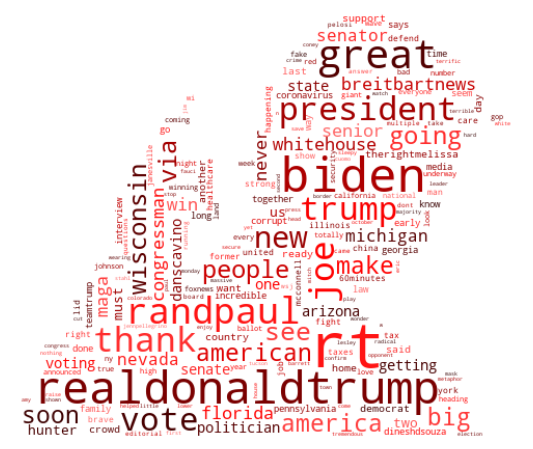

In [25]:
trump_text_clean = ' '.join(df_trump['text_clean'])
trump_picture = '../input/d/foolwuilin/picture/sentiment_02.jpg'

mask = np.array(Image.open(trump_picture))
plt.subplots(figsize=(16, 8))
wc = WordCloud(width=mask.shape[1], height=mask.shape[0], max_font_size=60, 
               collocations=False, mask=mask, background_color='white',
              random_state=44, color_func=similar_color_red).generate(trump_text_clean)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()


Search the messages that Biden and Trump mentioned each other. Then, plot a line chart to understand the frequency that the name is mentioned.

In [26]:
df_biden['create_time']= pd.to_datetime(df_biden['create_time'])
df_biden = df_biden.set_index('create_time')
df_biden

,text,retweets,favorites,word_tokens,text_clean,polarity,subjectivity
create_time,,,,,,,
2020-10-22 00:30:00+00:00,"Folks, if you plan to vote by mail and haven’t...",1181,4677.00,25,folks plan vote mail havent requested ballot y...,0.4000,1.000000
2020-10-21 23:50:00+00:00,Vote early.\n\nVote by mail.\n\nVote on Electi...,2921,19363.00,15,vote early vote mail vote election day make su...,0.3000,0.594444
2020-10-21 23:15:00+00:00,President Trump didn't take the necessary prec...,10607,74966.00,21,president trump take necessary precautions pro...,0.0000,1.000000
2020-10-21 21:47:08+00:00,I couldn’t be more excited to have my friend @...,4454,28721.00,21,couldnt excited friend barackobama hitting cam...,0.3125,0.541667
2020-10-21 21:05:00+00:00,It’s time we replace Secretary Betsy DeVos wit...,14701,84864.00,20,time replace secretary betsy devos actual publ...,0.0000,0.077778
...,...,...,...,...,...,...,...
2020-10-09 21:25:20+00:00,Tune in as I deliver remarks from our drive-in...,2846,12931.00,13,tune deliver remarks event las vegas,0.0000,0.000000
2020-10-09 20:05:00+00:00,"It’s estimated that nearly another 200,000 Ame...",18085,99806.00,20,estimated nearly another americans could lose ...,0.1000,0.400000
2020-10-09 18:52:00+00:00,Why did Donald Trump tell Bob Woodward the tru...,45574,295094.00,15,donald trump tell bob woodward truth american ...,0.0000,0.000000


In [27]:
df_trump['create_time']= pd.to_datetime(df_trump['create_time'])
df_trump = df_trump.set_index('create_time')
df_trump

,text,retweets,favorites,word_tokens,text_clean,polarity,subjectivity
create_time,,,,,,,
2020-10-21 22:41:26+00:00,Exclusive: Forgotten by Obama-Biden Auto Bailo...,6171,18497.00,17,exclusive forgotten auto bailout delphi worker...,0.000,0.00
2020-10-21 22:41:19+00:00,Multiple Pro-Trump Demonstrations Planned in C...,6555,26744.00,9,multiple demonstrations planned cincinnati are...,0.000,0.00
2020-10-21 22:33:24+00:00,Pennsylvania Trump Voters Show Passion: ‘He‘s ...,6033,24106.00,20,pennsylvania trump voters show passion hes man...,0.200,0.10
2020-10-21 22:31:37+00:00,WSJ Editorial Board: Joe Biden Must Answer Que...,9732,29527.00,16,wsj editorial board joe biden must answer ques...,0.000,0.00
2020-10-21 21:57:10+00:00,See you soon North Carolina! https://t.co/MWfy...,6711,33761.00,7,see soon north carolina,0.000,0.00
...,...,...,...,...,...,...,...
2020-10-16 11:00:50+00:00,Thank you LIBERTARIANS. We are getting it all ...,14286,62059.00,14,thank libertarians getting done fast vote trump,0.200,0.60
2020-10-16 10:57:56+00:00,RT @RandPaul: #AmyConeyBarrett will make an ex...,12820,96763.49,21,rt randpaul amyconeybarrett make excellent jus...,1.000,1.00
2020-10-16 10:57:47+00:00,RT @RandPaul: Democrats seem to think all just...,7879,96763.49,24,rt randpaul democrats seem think justices poli...,0.000,0.00


In [28]:
biden_trump = df_biden['text'].str.contains('trump', case=False)
print(np.sum(biden_trump)/df_biden.shape[0])

0.17


In [29]:
trump_biden = df_trump['text'].str.contains('biden', case=False)
print(np.sum(trump_biden)/df_trump.shape[0])

0.18


In [30]:
biden_trump_day = biden_trump.resample('1440min').mean().round(2)
biden_trump_day

create_time
2020-10-09 00:00:00+00:00    0.14
2020-10-10 00:00:00+00:00    0.00
2020-10-11 00:00:00+00:00    0.30
2020-10-12 00:00:00+00:00    0.13
2020-10-13 00:00:00+00:00    0.24
2020-10-14 00:00:00+00:00    0.20
2020-10-15 00:00:00+00:00    0.18
2020-10-16 00:00:00+00:00    0.15
2020-10-17 00:00:00+00:00    0.15
2020-10-18 00:00:00+00:00    0.21
2020-10-19 00:00:00+00:00    0.08
2020-10-20 00:00:00+00:00    0.20
2020-10-21 00:00:00+00:00    0.20
2020-10-22 00:00:00+00:00    0.00
Freq: 1440T, Name: text, dtype: float64

In [31]:
trump_biden_day = trump_biden.resample('1440min').mean().round(2)
trump_biden_day

create_time
2020-10-16 00:00:00+00:00    0.08
2020-10-17 00:00:00+00:00    0.20
2020-10-18 00:00:00+00:00    0.32
2020-10-19 00:00:00+00:00    0.07
2020-10-20 00:00:00+00:00    0.25
2020-10-21 00:00:00+00:00    0.19
Freq: 1440T, Name: text, dtype: float64

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=biden_trump_day.index.day,
    y=biden_trump_day,
    line_color='rgb(0,100,80)',
    showlegend=True,
    name='Biden Mentioned Trump',
))
fig.add_trace(go.Scatter(
    x=trump_biden_day.index.day, 
    y=trump_biden_day,
    line_color='rgb(231,107,243)',
    showlegend=True,
    name='Trump Mentioned Biden',
))
fig.update_layout({  
      'showlegend':True, 'legend':{'x':0.2, 'y':0.96, 'bgcolor':'rgb(246, 228, 129)'}
      })
fig.update_xaxes(
        title_text = "Oct 2020",
        title_font = {"size": 16},
        title_standoff = 12)
fig.update_yaxes(
        title_text = "Average Mention Times",
        title_font = {"size": 16},
        title_standoff = 12)
fig.update_traces(mode='lines')
fig.show()

In [33]:
df_biden_reset = df_biden.reset_index()
df_biden_reset['Oct'] = df_biden_reset['create_time'].dt.strftime('%d')
df_biden_pol = df_biden_reset.groupby('Oct').agg({'polarity':'mean'})
df_biden_pol

,polarity
Oct,
09,-0.014286
10,0.074040
11,-0.023333
12,0.037778
13,0.122891
14,0.063333
15,-0.015358
16,0.067958
17,0.071445


In [34]:
df_trump_reset = df_trump.reset_index()
df_trump_reset['Oct'] = df_trump_reset['create_time'].dt.strftime('%d')
df_trump_pol = df_trump_reset.groupby('Oct').agg({'polarity':'mean'})
df_trump_pol

,polarity
Oct,
16,0.132114
17,0.101231
18,0.074975
19,0.186315
20,0.142689
21,0.186187


In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_biden_pol.index,
    y=df_biden_pol['polarity'],
    line_color='rgb(0,100,80)',
    showlegend=True,
    name='Sentiment (Biden Mentioned Trump)',
))
fig.add_trace(go.Scatter(
    x=df_trump_pol.index, 
    y=df_trump_pol['polarity'],
    line_color='rgb(231,107,243)',
    showlegend=True,
    name='Sentiment (Trump Mentioned Biden)',
))
fig.update_layout({  
      'showlegend':True, 'legend':{'x':0.02, 'y':0.96, 'bgcolor':'rgb(246, 228, 129)'}
      })
fig.update_xaxes(
        title_text = "Oct 2020",
        title_font = {"size": 16},
        title_standoff = 12)
fig.update_yaxes(
        title_text = "Average Mention Times",
        title_font = {"size": 16},
        title_standoff = 12)
fig.update_traces(mode='lines')
fig.show()


Time to understand how vice-president retweeted the message. Where are these message from? It is ideal to know the situation by plotting the networks.

In [36]:
harris_network = pd.json_normalize(harris_data)
harris_network = harris_network[['user.screen_name', 'retweeted_status.user.screen_name']]
harris_network

,user.screen_name,retweeted_status.user.screen_name
0,KamalaHarris,NaN
1,KamalaHarris,NaN
2,KamalaHarris,NaN
3,KamalaHarris,NaN
4,KamalaHarris,JoeBiden
...,...,...
195,KamalaHarris,JoeBiden
196,KamalaHarris,NaN
197,KamalaHarris,JoeBiden
198,KamalaHarris,NaN


In [37]:
harris_network = harris_network.dropna(axis=0)

harris_retweeted_G = nx.from_pandas_edgelist(
    harris_network,
    source = 'user.screen_name',
    target = 'retweeted_status.user.screen_name',
    create_using = nx.DiGraph())
 
print('Nodes in RT network:', len(harris_retweeted_G.nodes()))
print('Edges in RT network:', len(harris_retweeted_G.edges()))

Nodes in RT network: 6
Edges in RT network: 5


In [38]:
harris_retweeted_G.nodes()

NodeView(('KamalaHarris', 'JoeBiden', 'DrBiden', 'TeamJoe', 'MichiganDems', 'DouglasEmhoff'))

In [39]:
harris_retweeted_G.edges()

OutEdgeView([('KamalaHarris', 'JoeBiden'), ('KamalaHarris', 'DrBiden'), ('KamalaHarris', 'TeamJoe'), ('KamalaHarris', 'MichiganDems'), ('KamalaHarris', 'DouglasEmhoff')])

In [40]:
retweet_bt = nx.in_degree_centrality(harris_retweeted_G)
harris_reteet_bt = pd.DataFrame(list(retweet_bt.items()), columns = ['screen_name', 'centrality'])
harris_reteet_bt = harris_reteet_bt.dropna(axis=0)
harris_reteet_bt

,screen_name,centrality
0,KamalaHarris,0.0
1,JoeBiden,0.2
2,DrBiden,0.2
3,TeamJoe,0.2
4,MichiganDems,0.2
5,DouglasEmhoff,0.2


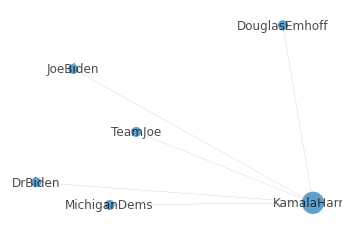

In [41]:
pos = nx.random_layout(harris_retweeted_G)

sizes = [x[1]*100 for x in harris_retweeted_G.degree()]

nx.draw_networkx(harris_retweeted_G, pos, 
    with_labels = True, 
    node_size = sizes,
    width = 0.1, alpha = 0.7,
    arrowsize = 2, linewidths = 0)

plt.axis('off')
plt.show()

In [42]:
pence_network = pd.json_normalize(pence_data)
pence_network = pence_network[['user.screen_name', 'retweeted_status.user.screen_name']]
pence_network

,user.screen_name,retweeted_status.user.screen_name
0,Mike_Pence,realDonaldTrump
1,Mike_Pence,realDonaldTrump
2,Mike_Pence,KarenPence
3,Mike_Pence,TeamTrump
4,Mike_Pence,TrumpWarRoom
...,...,...
194,Mike_Pence,realDonaldTrump
195,Mike_Pence,SecondLady
196,Mike_Pence,SecondLady
197,Mike_Pence,TeamTrump


In [43]:
trump_network = pd.json_normalize(trump_data)
trump_network = trump_network[['user.screen_name', 'retweeted_status.user.screen_name']]
trump_network

,user.screen_name,retweeted_status.user.screen_name
0,realDonaldTrump,NaN
1,realDonaldTrump,NaN
2,realDonaldTrump,NaN
3,realDonaldTrump,NaN
4,realDonaldTrump,NaN
...,...,...
195,realDonaldTrump,NaN
196,realDonaldTrump,RandPaul
197,realDonaldTrump,RandPaul
198,realDonaldTrump,NaN


In [44]:
network = pd.concat([pence_network, trump_network], axis=0)
network = network.dropna(axis=0)
network

,user.screen_name,retweeted_status.user.screen_name
0,Mike_Pence,realDonaldTrump
1,Mike_Pence,realDonaldTrump
2,Mike_Pence,KarenPence
3,Mike_Pence,TeamTrump
4,Mike_Pence,TrumpWarRoom
...,...,...
192,realDonaldTrump,AmericanEsther
193,realDonaldTrump,cjtruth
194,realDonaldTrump,RandPaul
196,realDonaldTrump,RandPaul


In [45]:
network_A = list(network["user.screen_name"].unique())
network_B = list(network["retweeted_status.user.screen_name"].unique())
node_list = list(set(network_A+network_B))
G = nx.Graph()
for i in node_list:
    G.add_node(i)
for i,j in network.iterrows():
    G.add_edges_from([(j["user.screen_name"],j["retweeted_status.user.screen_name"])])
pos = nx.spring_layout(G, k=0.5, dim=2, iterations=80)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=15,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0]) +' has {} connections'.format(str(len(adjacencies[1])))
    node_trace['text']+=tuple([node_info])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Retweet Network',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
iplot(fig)

In [46]:
network

,user.screen_name,retweeted_status.user.screen_name
0,Mike_Pence,realDonaldTrump
1,Mike_Pence,realDonaldTrump
2,Mike_Pence,KarenPence
3,Mike_Pence,TeamTrump
4,Mike_Pence,TrumpWarRoom
...,...,...
192,realDonaldTrump,AmericanEsther
193,realDonaldTrump,cjtruth
194,realDonaldTrump,RandPaul
196,realDonaldTrump,RandPaul


In [47]:
#Another network plot by igraph
network_A = list(network["user.screen_name"].unique())
network_B = list(network["retweeted_status.user.screen_name"].unique())
G = ig.Graph.DataFrame(network, directed=False)
labels = list(set(network_A + network_B))
N=len(labels)
E=[e.tuple for e in G.es]
layt=G.layout('kk')

Xn=[layt[k][0] for k in range(N)]
Yn=[layt[k][1] for k in range(N)]
Xe=[]
Ye=[]
for e in E:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]

trace1=Scatter(x=Xe,
               y=Ye,
               mode='lines',
               line= dict(color='rgb(210,210,210)', width=1),
               hoverinfo='none'
               )

trace2=Scatter(x=Xn,
               y=Yn,
               mode='markers',
               name='ntw',
               marker=dict(symbol='circle-dot',
                           size=10,
                           color='#6959CD',
                           line=dict(color='rgb(50,50,50)', width=0.5)
                          ),
               text=labels,
               hoverinfo='text'
               )

axis=dict(showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

width=800
height=800
layout=Layout(title= "test",
    font= dict(size=12),
    showlegend=False,
    autosize=False,
    width=width,
    height=height,
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )

data=[trace1, trace2]
fig=Figure(data=data, layout=layout)
iplot(fig)

## 3.2 EDA Summary
In this section, there are several findings as below.
1. When Biden posted at 12 pm, the posts got the most retweets and likes. In contrast, Trump got more retweets and likes when posting from 1 pm to 3 pm.
2. The WordCloud graphics demonstrate Biden and Trump usually mentioned to each other.
3. Because of a lack of data, it is hard to tell the difference of how they mentioned to each other.
4. Pence and Trump frequently retweet each other's posts.

## 4. Analyze
Give a level by scoring the likes. This is the criterion for machine learning to train the model and then predict the like level is going to be when posting. 

In [48]:
df_biden['like_core']=pd.qcut(df_biden['favorites'].rank(method='first'), q=3, labels=range(1,4))
df_biden.head()

,text,retweets,favorites,word_tokens,text_clean,polarity,subjectivity,like_core
create_time,,,,,,,,
2020-10-22 00:30:00+00:00,"Folks, if you plan to vote by mail and haven’t...",1181,4677.0,25,folks plan vote mail havent requested ballot y...,0.4000,1.000000,1
2020-10-21 23:50:00+00:00,Vote early.\n\nVote by mail.\n\nVote on Electi...,2921,19363.0,15,vote early vote mail vote election day make su...,0.3000,0.594444,1
2020-10-21 23:15:00+00:00,President Trump didn't take the necessary prec...,10607,74966.0,21,president trump take necessary precautions pro...,0.0000,1.000000,2
2020-10-21 21:47:08+00:00,I couldn’t be more excited to have my friend @...,4454,28721.0,21,couldnt excited friend barackobama hitting cam...,0.3125,0.541667,1
2020-10-21 21:05:00+00:00,It’s time we replace Secretary Betsy DeVos wit...,14701,84864.0,20,time replace secretary betsy devos actual publ...,0.0000,0.077778,2


In [49]:
biden_tv=TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2), max_features=1000,token_pattern=r'\b[^\d\W][^\d\W]+\b').fit(df_biden['text_clean'])
biden_tranformed = biden_tv.transform(df_biden['text_clean'])
biden_matrix = pd.DataFrame(biden_tranformed.toarray(), columns=biden_tv.get_feature_names())
biden_matrix

,abc,able,absentee,actually,administration,afford,ahead,america,american,american people,...,years sees,years unlimited,yes,yest,yesterday,yesterday realdonaldtrump,yo,young,young women,youre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287181,0.318434,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
X_b = biden_matrix
y_b = df_biden['like_core']

c_space = np.arange(1, 50)
param_grid = {'C': c_space, 'penalty': ['none', 'l2']}

X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.2, random_state=44)
logreg = LogisticRegression(max_iter=1000, random_state=44)
logreg_cv = GridSearchCV(logreg, param_grid=param_grid,
                 refit=True, cv=3, n_jobs=24)
logreg_cv.fit(X_b_train, y_b_train)
logreg_best = logreg_cv.best_estimator_
logreg_best.fit(X_b_train, y_b_train)
y_b_predicted = logreg_best.predict(X_b_test)

print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))
print('Test Accuracy (Biden) -', accuracy_score(y_b_test, y_b_predicted))
print(confusion_matrix(y_b_test, y_b_predicted))
print("Test Classification Report (Biden)\n", classification_report(y_b_test, y_b_predicted))

Tuned Logistic Regression Parameter: {'C': 14, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.5690659212671791
Test Accuracy (Biden) - 0.675
[[ 7  3  1]
 [ 1  7  5]
 [ 0  3 13]]
Test Classification Report (Biden)
               precision    recall  f1-score   support

           1       0.88      0.64      0.74        11
           2       0.54      0.54      0.54        13
           3       0.68      0.81      0.74        16

    accuracy                           0.68        40
   macro avg       0.70      0.66      0.67        40
weighted avg       0.69      0.68      0.67        40



In [51]:
df_trump['like_core']=pd.qcut(df_trump['favorites'].rank(method='first'), q=3, labels=range(1,4))
df_trump.head()

,text,retweets,favorites,word_tokens,text_clean,polarity,subjectivity,like_core
create_time,,,,,,,,
2020-10-21 22:41:26+00:00,Exclusive: Forgotten by Obama-Biden Auto Bailo...,6171,18497.0,17,exclusive forgotten auto bailout delphi worker...,0.0,0.0,1
2020-10-21 22:41:19+00:00,Multiple Pro-Trump Demonstrations Planned in C...,6555,26744.0,9,multiple demonstrations planned cincinnati are...,0.0,0.0,1
2020-10-21 22:33:24+00:00,Pennsylvania Trump Voters Show Passion: ‘He‘s ...,6033,24106.0,20,pennsylvania trump voters show passion hes man...,0.2,0.1,1
2020-10-21 22:31:37+00:00,WSJ Editorial Board: Joe Biden Must Answer Que...,9732,29527.0,16,wsj editorial board joe biden must answer ques...,0.0,0.0,1
2020-10-21 21:57:10+00:00,See you soon North Carolina! https://t.co/MWfy...,6711,33761.0,7,see soon north carolina,0.0,0.0,1


In [52]:
trump_tv=TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2), max_features=1000,token_pattern=r'\b[^\d\W][^\d\W]+\b').fit(df_trump['text_clean'])
trump_tranformed = biden_tv.transform(df_trump['text_clean'])
trump_matrix = pd.DataFrame(trump_tranformed.toarray(), columns=trump_tv.get_feature_names())
trump_matrix

,absolutely,america,america great,american,american seniors,americans,amy,amy coney,announced,answer,...,year joe,years,years whi,yesterday,yesterday proamericarally,yo,york,york california,york fiercely,york ghost
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.338003,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
X_t = trump_matrix
y_t = df_trump['like_core']

c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['none', 'l2']}

X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_t, y_t, test_size=0.2, random_state=44)
logreg = LogisticRegression(max_iter=1000, random_state=44)
logreg_cv = GridSearchCV(logreg, param_grid=param_grid,
                 refit=True, cv=3, n_jobs=24)
logreg_cv.fit(X_t_train, y_t_train)
logreg_best = logreg_cv.best_estimator_
logreg_best.fit(X_t_train, y_t_train)
y_t_predicted = logreg_best.predict(X_t_test)

print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))
print('Test Accuracy (Trump) -', accuracy_score(y_t_test, y_t_predicted))
print(confusion_matrix(y_t_test, y_t_predicted))
print("Test Classification Report (Trump)\n", classification_report(y_t_test, y_t_predicted))

Tuned Logistic Regression Parameter: {'C': 0.4393970560760795, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.681341719077568
Test Accuracy (Trump) - 0.525
[[9 0 1]
 [5 9 2]
 [5 6 3]]
Test Classification Report (Trump)
               precision    recall  f1-score   support

           1       0.47      0.90      0.62        10
           2       0.60      0.56      0.58        16
           3       0.50      0.21      0.30        14

    accuracy                           0.53        40
   macro avg       0.52      0.56      0.50        40
weighted avg       0.53      0.53      0.49        40



# 5. Conclusion
After building the models, the accuracy of the prediction for Biden is 70%. Although this number is not ideal, the prediction seems not so bad if looking into the confusion matrix. When predicting the like level is 1, 8 posts are correctly predicted. 3 posts are predicted as 2. It is good that no post is actually 3, which should be a post with many likes.

When predicting posts as 2, 7 posts are correctly predicted. 5 posts are predicted as level 2, but actually, they are level 3. The good thing is that only 1 post is predicted as level 2 but actually gets a lower number of likes, which means only 1 post will come below the expectation.

As for 15 posts predicted as level 3, only 3 posts are below the expectation as level 2. No post is actually level 1. These are a good sign for accuracy, although it is only 70%.

In contrast, The prediction for Trump's posts is not so good. The accuracy is only 57.5%. Also, in regards to the predicted posts as level 3, 4 posts are actually in level 1. 5 posts are predicted as level 2, but they are the posts getting lower likes. This situation is way below the expectation, which is not acceptable. This situation tells there is more noise in Trump's posts. It is more difficult to predict the taste of the audience. Plus, it generates more uncertainty when the election.